# Part 1

### Task A: Network Construction

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
from collections import defaultdict

In [6]:
# Setting the data path
DATA_DIR = '../data/'
# Choose dataset
FILES = {
    "small": "PROPERTIES_FOR_DELETION.csv",
    "medium": "USERS.csv",
    "large": "REQUEST_FOR_DELETION.csv"
}

In [7]:
# Read sample data (small)
small_df = pd.read_csv(os.path.join(DATA_DIR, FILES["small"]))
small_df.head()

,thread_subject,username,page_name
0,{{PfD|Property:P1549}},Jc86035,WikidataPropertiesfordeletion.json
1,{{PfD|Property:P1549}},Jura1,WikidataPropertiesfordeletion.json
2,{{PfD|Property:P1549}},Máté,WikidataPropertiesfordeletion.json
3,{{PfD|Property:P1549}},Autom,WikidataPropertiesfordeletion.json
4,{{PfD|Property:P1549}},Nikki,WikidataPropertiesfordeletion.json


As the column names are not concise and consistent, we renamed them: thread, user, page.

In [8]:
# Rename the column names
small_df = small_df.rename(columns={
    "thread_subject": "thread",
    "username": "user",
    "page_name": "page"
})

# Check the renamed dataset
small_df.head()

,thread,user,page
0,{{PfD|Property:P1549}},Jc86035,WikidataPropertiesfordeletion.json
1,{{PfD|Property:P1549}},Jura1,WikidataPropertiesfordeletion.json
2,{{PfD|Property:P1549}},Máté,WikidataPropertiesfordeletion.json
3,{{PfD|Property:P1549}},Autom,WikidataPropertiesfordeletion.json
4,{{PfD|Property:P1549}},Nikki,WikidataPropertiesfordeletion.json


In [9]:
# Creating a graph object
G_small = nx.Graph()

# Group by thread + page
grouped = small_df.groupby(["page", "thread"])

# Establish all the edge combinations of each other for each group of users
for (page, thread), group in grouped:
    users = group['user'].unique()
    for i, u1 in enumerate(users):
        for u2 in users[i+1:]:
            if G_small.has_edge(u1, u2):
                G_small[u1][u2]['weight'] += 1
            else:
                G_small.add_edge(u1, u2, weight=1)

print(f"There are {G_small.number_of_nodes()} user nodes and {G_small.number_of_edges()} edges in the network.")

There are 737 user nodes and 13530 edges in the network.


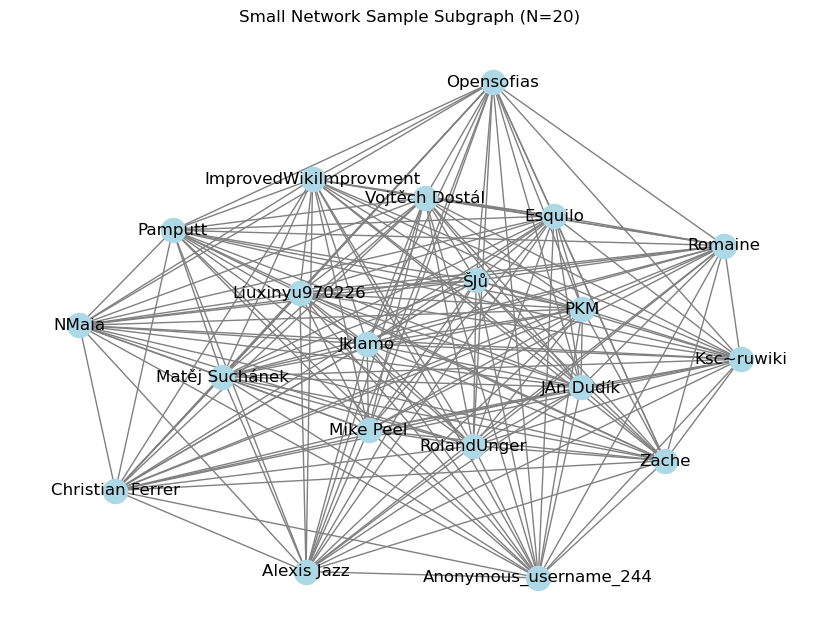

In [12]:
# Draw a subgraph consisting of the first N nodes for display (e.g. N=20）
N = 20
nodes_to_draw = list(G_small.nodes())[:N]
subgraph = G_small.subgraph(nodes_to_draw)

plt.figure(figsize=(8, 6))
nx.draw(subgraph, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Small Network Sample Subgraph (N=20)")
plt.show()

We encapsulate a function build_editor_network so that it can be reused in the subsequent processing of medium and large data sets.

In [13]:
# Constructing editor network general function
def build_editor_network(df, node_col="user", thread_col="thread", page_col="page"):
    G = nx.Graph()
    grouped = df.groupby([page_col, thread_col])
    
    for (_, _), group in grouped:
        users = group[node_col].unique()
        for i, u1 in enumerate(users):
            for u2 in users[i+1:]:
                if G.has_edge(u1, u2):
                    G[u1][u2]['weight'] += 1
                else:
                    G.add_edge(u1, u2, weight=1)
    
    return G

In [14]:
# Constructing a small network graph
G_small = build_editor_network(small_df)

# Basic information output
print(f"[Small Network] Nodes: {G_small.number_of_nodes()}, Edges: {G_small.number_of_edges()}")

[Small Network] Nodes: 737, Edges: 13530


In [15]:
# Draw a subgraph consisting of the first N nodes in the graph
def plot_sample_subgraph(G, N=20, title="Sample Network"):
    nodes_to_draw = list(G.nodes())[:N]
    subgraph = G.subgraph(nodes_to_draw)

    plt.figure(figsize=(8, 6))
    nx.draw(subgraph, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title(f"{title} (N={N})")
    plt.show()

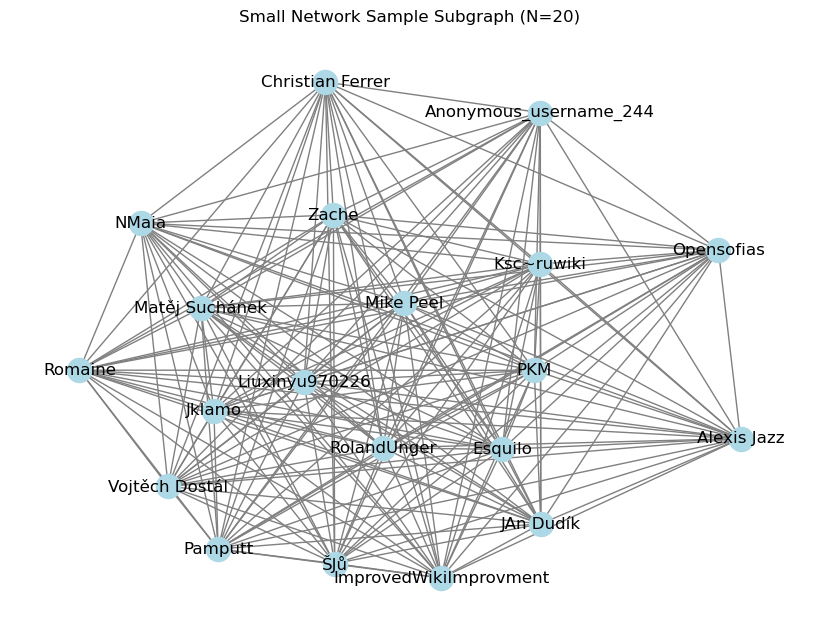

In [16]:
plot_sample_subgraph(G_small, N=20, title="Small Network Sample Subgraph")

[Medium Network] Nodes: 8390, Edges: 24692


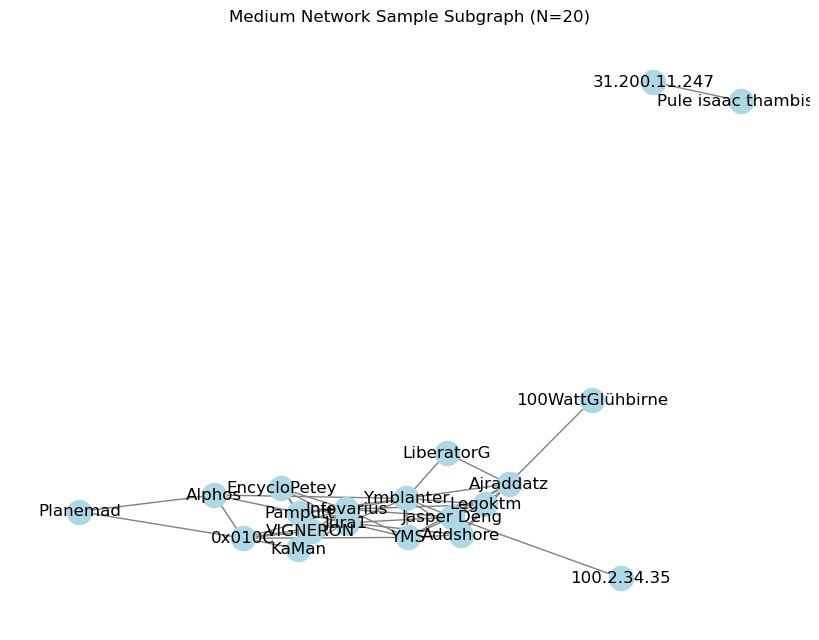

In [20]:
# Read medium data
medium_df = pd.read_csv(os.path.join(DATA_DIR, FILES["medium"]))
medium_df = medium_df.rename(columns={
    "thread_subject": "thread",
    "username": "user",
    "page_name": "page"
})

# Construct the Medium Network Graph
G_medium = build_editor_network(medium_df)

# Output basic information
print(f"[Medium Network] Nodes: {G_medium.number_of_nodes()}, Edges: {G_medium.number_of_edges()}")

# Visualize a subgraph of the first 20 nodes of the medium network
plot_sample_subgraph(G_medium, N=20, title="Medium Network Sample Subgraph")

[Large Network] Nodes: 9887, Edges: 33488


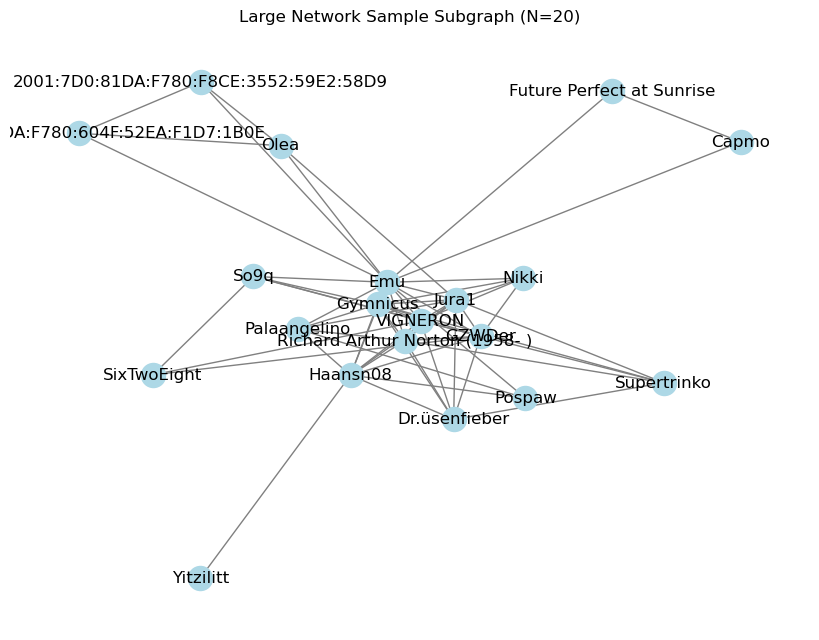

In [21]:
# Read large data
large_df = pd.read_csv(os.path.join(DATA_DIR, FILES["large"]))
large_df = large_df.rename(columns={
    "thread_subject": "thread",
    "username": "user",
    "page_name": "page"
})

# Construct a large network graph
G_large = build_editor_network(large_df)

# Output basic information
print(f"[Large Network] Nodes: {G_large.number_of_nodes()}, Edges: {G_large.number_of_edges()}")

# Visualize a subgraph of the first 20 nodes of the large network
plot_sample_subgraph(G_large, N=20, title="Large Network Sample Subgraph")

In [25]:
# Create a map of network size and graph
networks = {
    "Small": G_small,
    "Medium": G_medium,
    "Large": G_large
}

# Print title
print(f"{'Network size':<10} {'Nodes':<10} {'Edges':<10}")
print("-" * 30)

# Traverse each network and print its number of nodes and edges
for name, G in networks.items():
    print(f"{name:<10} {G.number_of_nodes():<10} {G.number_of_edges():<10}")

Network size Nodes      Edges     
------------------------------
Small      737        13530     
Medium     8390       24692     
Large      9887       33488     


### Task B: Network Metrics

In [33]:
import numpy as np

In [34]:
def analyze_network(G, name=""):
    print(f"[{name}] Network Analysis")
    print("-" * 40)
    
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degrees = [deg for _, deg in G.degree()]
    mean_degree = np.mean(degrees)
    clustering = nx.average_clustering(G)
    
    is_connected = nx.is_connected(G)
    print(f"Connected: {is_connected}")
    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Average Degree: {mean_degree:.2f}")
    print(f"Average Clustering Coefficient: {clustering:.4f}")
    
    if is_connected:
        diameter = nx.diameter(G)
        avg_path_length = nx.average_shortest_path_length(G)
        print(f"Diameter: {diameter}")
        print(f"Avg Shortest Path Length: {avg_path_length:.2f}")
    else:
        print("Diameter: Not computed (graph not connected)")
        print("Avg Shortest Path Length: Not computed")
    
    # Plot degree distribution
    plt.figure(figsize=(6,4))
    plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Degree Distribution: {name}")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[Small Network] Network Analysis
----------------------------------------
Connected: False
Nodes: 737
Edges: 13530
Average Degree: 36.72
Average Clustering Coefficient: 0.7935
Diameter: Not computed (graph not connected)
Avg Shortest Path Length: Not computed


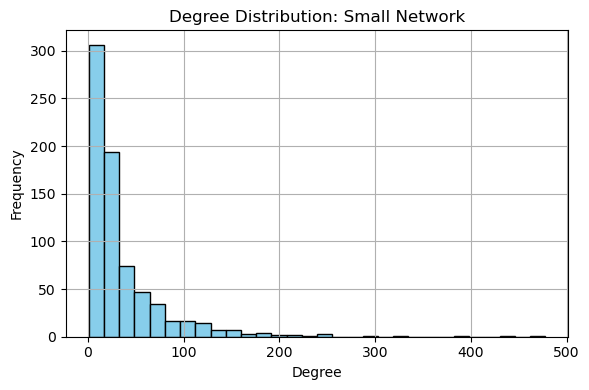

[Medium Network] Network Analysis
----------------------------------------
Connected: False
Nodes: 8390
Edges: 24692
Average Degree: 5.89
Average Clustering Coefficient: 0.2480
Diameter: Not computed (graph not connected)
Avg Shortest Path Length: Not computed


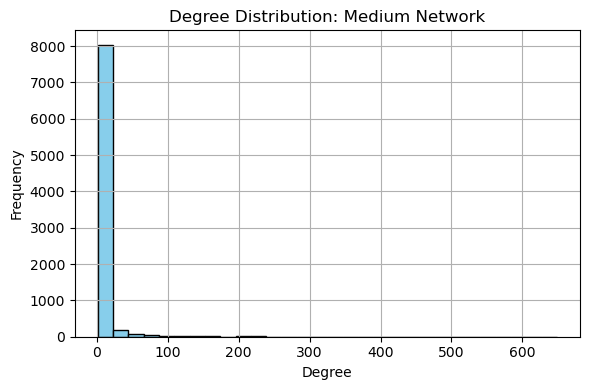

[Large Network] Network Analysis
----------------------------------------
Connected: False
Nodes: 9887
Edges: 33488
Average Degree: 6.77
Average Clustering Coefficient: 0.3938
Diameter: Not computed (graph not connected)
Avg Shortest Path Length: Not computed


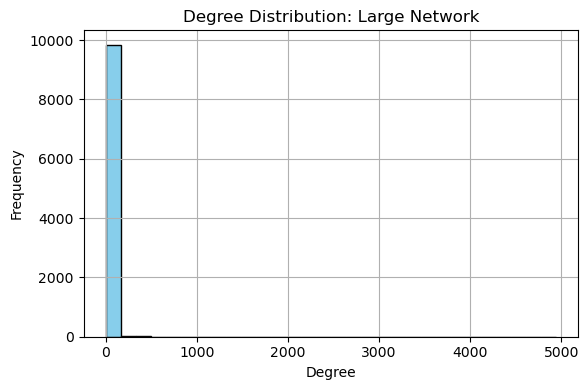

In [35]:
analyze_network(G_small, name="Small Network")
analyze_network(G_medium, name="Medium Network")
analyze_network(G_large, name="Large Network")

In [39]:
# Compare network G to a random network of the same size.
def compare_with_random(G, name=""):
    print(f"\n[{name} Network] Comparison with Random Graph")
    print("-" * 50)
    
    n = G.number_of_nodes()
    m = G.number_of_edges()

    # Generate random graph
    G_random = nx.gnm_random_graph(n, m, seed=42)

    # Calculate the clustering coefficient
    cc_real = nx.average_clustering(G)
    cc_rand = nx.average_clustering(G_random)

    # Calculate the shortest path and make sure it is a connected graph
    try:
        spl_real = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        spl_real = "Not connected"

    try:
        spl_rand = nx.average_shortest_path_length(G_random)
    except nx.NetworkXError:
        spl_rand = "Not connected"

    print(f"Average Clustering Coefficient: Real = {cc_real:.4f}, Random = {cc_rand:.4f}")
    print(f"Average Shortest Path Length:    Real = {spl_real}, Random = {spl_rand}")

In [40]:
# Compare with random
compare_with_random(G_small, name="Small")
compare_with_random(G_medium, name="Medium")
compare_with_random(G_large, name="Large")


[Small Network] Comparison with Random Graph
--------------------------------------------------
Average Clustering Coefficient: Real = 0.7935, Random = 0.0494
Average Shortest Path Length:    Real = Not connected, Random = 2.1024570821780424

[Medium Network] Comparison with Random Graph
--------------------------------------------------
Average Clustering Coefficient: Real = 0.2480, Random = 0.0007
Average Shortest Path Length:    Real = Not connected, Random = Not connected

[Large Network] Comparison with Random Graph
--------------------------------------------------
Average Clustering Coefficient: Real = 0.3938, Random = 0.0006
Average Shortest Path Length:    Real = Not connected, Random = Not connected


### Task C: Epidemic Models

In [52]:
import ndlib.models.ModelConfig as mc
from ndlib.models.epidemics import SIRModel
import random

In [62]:
def simulate_sir_model(graph, initial_infected_nodes, beta=0.05, gamma=0.01, iterations=30):
    # Prevent modification of the original image
    G = graph.copy()

    # Initialize the model
    model = SIRModel(G)

    # Configuring model parameters
    config = mc.Configuration()
    config.add_model_parameter("beta", beta)   # Transmission rate
    config.add_model_parameter("gamma", gamma) # Recovery rate
    config.add_model_parameter("fraction_infected", 0)  # Initialize to empty

    # Set up the initial infection
    config.add_model_initial_configuration("Infected", initial_infected_nodes)

    model.set_initial_status(config)

    # Run the simulation
    iterations = model.iteration_bunch(iterations)

    # Extracting data
    infected = [it['node_count'][1] for it in iterations]
    recovered = [it['node_count'][2] for it in iterations]
    susceptible = [it['node_count'][0] for it in iterations]

    # Draw plot
    plt.figure(figsize=(8, 5))
    plt.plot(susceptible, label="Susceptible", color='blue')
    plt.plot(infected, label="Infected", color='red')
    plt.plot(recovered, label="Recovered", color='green')
    plt.xlabel("Iteration")
    plt.ylabel("Number of Editors")
    plt.title("SIR Simulation on Wikidata Editor Network")
    plt.legend()
    plt.grid(True)
    plt.show()

In [63]:
for n in list(G_large.nodes())[:20]:
    print(repr(n), type(n))

'Gymnicus' <class 'str'>
'Richard Arthur Norton (1958- )' <class 'str'>
'Jura1' <class 'str'>
'Supertrinko' <class 'str'>
'GZWDer' <class 'str'>
'Dr.üsenfieber' <class 'str'>
'2001:7D0:81DA:F780:604F:52EA:F1D7:1B0E' <class 'str'>
'Emu' <class 'str'>
'Olea' <class 'str'>
'2001:7D0:81DA:F780:F8CE:3552:59E2:58D9' <class 'str'>
'Nikki' <class 'str'>
'Future Perfect at Sunrise' <class 'str'>
'Capmo' <class 'str'>
'Haansn08' <class 'str'>
'Pospaw' <class 'str'>
'Palaangelino' <class 'str'>
'Yitzilitt' <class 'str'>
'So9q' <class 'str'>
'VIGNERON' <class 'str'>
'SixTwoEight' <class 'str'>


In [66]:
# Build a mapping of users to IDs
user_to_id = {user: idx for idx, user in enumerate(G_large.nodes())}
id_to_user = {idx: user for user, idx in user_to_id.items()}

# Construct a new graph, using integer nodes
G_large_int = nx.Graph()
for u, v, data in G_large.edges(data=True):
    G_large_int.add_edge(user_to_id[u], user_to_id[v], **data)

print(f"The reconstructed graph has {G_large_int.number_of_nodes()} integer nodes")

The reconstructed graph has 9887 integer nodes


Initial infected node IDs: [2151, 6077]
The original usernames are: ['Christian COGNEAUX', 'ArdiPras95']


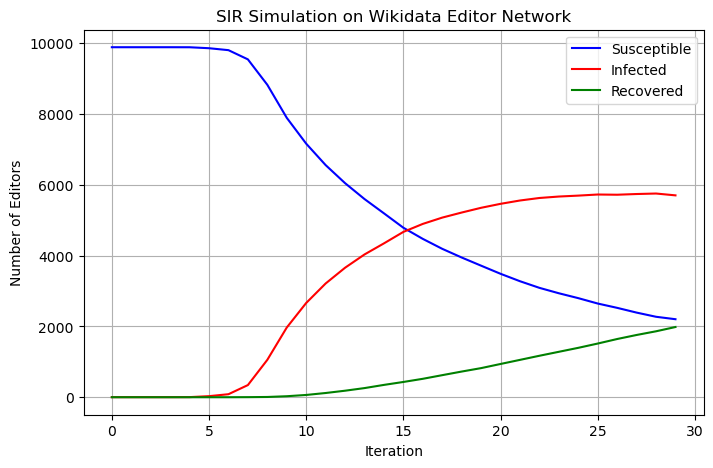

In [69]:
# Reselect 2 integer ID nodes as "suspected trolls"
initial_trolls_int = random.sample(list(G_large_int.nodes()), 2)
print("Initial infected node IDs:", initial_trolls_int)
print("The original usernames are:", [id_to_user[i] for i in initial_trolls_int])

# Call the simulate_sir_model function
simulate_sir_model(G_large_int, initial_trolls_int, beta=0.05, gamma=0.02, iterations=30)

In [73]:
# Calculate a prioritized checklist of potential spreaders, sorted in descending order of risk of transmission.
def compute_priority_list(G, infected_ids, top_n=10):
    scores = {}

    for node in G.nodes():
        if node in infected_ids:
            continue  # Skip known infected

        # Calculate the shortest path distance to all troll nodes (take the minimum)
        try:
            min_distance = min([nx.shortest_path_length(G, source=node, target=inf) for inf in infected_ids])
        except nx.NetworkXNoPath:
            min_distance = float('inf')

        # Count the number of common neighbors with troll
        common_neighbors = sum([
            len(list(nx.common_neighbors(G, node, inf))) if nx.has_path(G, node, inf) else 0
            for inf in infected_ids
        ])

        # The degree of the node
        degree = G.degree(node)

        # Transmission risk score (comprehensive score, close distance + many neighbors + high activity)
        if min_distance != float('inf'):
            score = (common_neighbors + 1) * (degree + 1) / (min_distance + 1)
        else:
            score = 0

        scores[node] = score

    # Sort by rating
    sorted_nodes = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_nodes[:top_n]

In [74]:
# Calculate the top 10 priority check users
priority_list = compute_priority_list(G_large_int, initial_trolls_int, top_n=10)

print("Top 10 Priority Editors to Check:")
for rank, (uid, score) in enumerate(priority_list, 1):
    print(f"{rank}. ID={uid} ({id_to_user[uid]}), Score={score:.4f}")

Top 10 Priority Editors to Check:
1. ID=24 (DeltaBot), Score=14820.0000
2. ID=1043 (BeneBot*), Score=8712.0000
3. ID=1297 (Cycn), Score=3224.0000
4. ID=91 (Lymantria), Score=2478.0000
5. ID=25 (MisterSynergy), Score=1663.6667
6. ID=7213 (Quakewoody), Score=1427.5000
7. ID=2 (Jura1), Score=1330.6667
8. ID=387 (Ymblanter), Score=1282.0000
9. ID=192 (분당선M), Score=1053.3333
10. ID=625 (Pasleim), Score=1040.0000
